In [1]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from kaveh.behavioral import oculomotor
from kaveh.sorting import spikesorter
from kaveh.toolbox import find_file
from kaveh.plots import axvlines
import numpy as np
from matplotlib import pyplot as plt
from smr import File
import csv
import os

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
def construct_x(aligned_spikes, time_npca, powers, freq_npca):
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import normalize
    
    pca = PCA(n_components = time_npca)
#     pca = PCA(n_components = time_npca, svd_solver = 'full')
    pca.fit(aligned_spikes)
    time_pca = pca.transform(aligned_spikes)
    time_pca = normalize(time_pca)
    print('time pca ', pca.explained_variance_ratio_)
    pca = PCA(n_components = freq_npca)
#     pca = PCA(n_components = time_npca, svd_solver = 'full')
    pca.fit(powers)
    print('freq pca ', pca.explained_variance_ratio_)
    freq_pca = pca.transform(powers)
    freq_pca = normalize(freq_pca)
    
    return np.concatenate((freq_pca, time_pca), 1)


def construct_y(spike_indices, cs_indices):
    from kaveh.toolbox import closest_argmin
    cs = closest_argmin(cs_indices, spike_indices)
    labeled = np.zeros(spike_indices.shape)
    labeled[cs] = 1.0
    
    return labeled


In [53]:
# construct training data
def prep_xy(f_name, num_spike_train, tpca, fpca):
    smr_content = File(f_name)
    smr_content.read_channels()
    voltage_chan = smr_content.get_channel(0)

    cs_path = '/mnt/data/temp/kaveh/auto_processed/' 
    cf = find_file(os.path.split(f_name)[1] + '.pkl', cs_path)
    with open(cf, 'rb') as input:
        sss = pickle.load(input)
    sss.voltage = voltage_chan.data

    from neo.io import Spike2IO
    neo_reader = Spike2IO(filename=f_name)
    neo_data = neo_reader.read()
    data_block = neo_data[0]
    seg = data_block.segments[0]
    # Assuming cs spike trains are saved in the 0th index of spike train channels
    cs_indices = np.array([])
    for i in range(num_spike_train+1):
        cs_indices = np.union1d(cs_indices, np.array(seg.spiketrains[i]))
    print(cs_indices.shape)
    cs_indices = np.int32(cs_indices/sss.dt)
    [_,powers,_] = sss._find_max_powers()

    train_x = construct_x(sss.aligned_spikes, tpca, powers, fpca)
    train_y = construct_y(sss.get_spike_indices(), cs_indices)
    return train_x, train_y

def prep_xy2(f_name, num_spike_train):
    smr_content = File(f_name)
    smr_content.read_channels()
    voltage_chan = smr_content.get_channel(0)

    cs_path = '/mnt/data/temp/kaveh/auto_processed/' 
    cf = find_file(os.path.split(f_name)[1] + '.pkl', cs_path)
    with open(cf, 'rb') as input:
        sss = pickle.load(input)
    sss.voltage = voltage_chan.data

    from neo.io import Spike2IO
    neo_reader = Spike2IO(filename=f_name)
    neo_data = neo_reader.read()
    data_block = neo_data[0]
    seg = data_block.segments[0]
    # Assuming cs spike trains are saved in the 0th index of spike train channels
    cs_indices = np.array([])
    for i in range(num_spike_train+1):
        cs_indices = np.union1d(cs_indices, np.array(seg.spiketrains[i]))
    print(cs_indices.shape)
    cs_indices = np.int32(cs_indices/sss.dt)
    train_x = sss.aligned_spikes
    train_y = construct_y(sss.get_spike_indices(), cs_indices)
    return train_x, train_y


(70233, 275)

In [54]:
f_names= [
         '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K48/error_direction/K48_2_CSddirTuning.smr',
         '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K69/error_direction/K69_1_DirTuning.smr',
         '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K69/error_magnitude/K69_1_ErrorSize45degDir.smr',
         '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K16/error_direction/K16_2_directionaltest.smr',
         '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Step/S38/error_direction/S38_1_directionaltuning.smr',
          '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O62/O62_1_FW5R_BW5L_A.smr',
          '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O62/O62_1_pre.smr',
         ]

cs_spiketrain_idx = [ 1, 1, 2, 0, 1, 2, 0]

x_train = np.array([])
y_train = np.array([])
for i, f_name in enumerate(f_names):
#     x, y = prep_xy(f_name, cs_spiketrain_idx[i], 100, 1)
    x, y = prep_xy2(f_name, cs_spiketrain_idx[i])

    x_train = np.vstack([x_train, x]) if x_train.size else x
    y_train = np.hstack([y_train, y]) if y_train.size else y
    

Not implemented (type = 6)
Not implemented (type = 5)
(659,)
Not implemented (type = 6)
Not implemented (type = 5)
(386,)
Not implemented (type = 6)
Not implemented (type = 5)
(1426,)
Not implemented (type = 6)
Not implemented (type = 5)
(2188,)
Not implemented (type = 6)
Not implemented (type = 5)
(1051,)
Not implemented (type = 6)
Not implemented (type = 5)


(657,)


Not implemented (type = 6)
Not implemented (type = 5)
(41,)


In [55]:
rand_idx = range(y_train.size)
np.random.shuffle(rand_idx)

x_train = x_train[rand_idx]
y_train = y_train[rand_idx]

In [56]:
from imblearn.under_sampling import RandomUnderSampler
# x_train, y_train = prep_xy(f_name)
print(x_train.shape)
print(y_train.shape)
rus = RandomUnderSampler(sampling_strategy = 1)
x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)
print(x_train_resampled.shape)
print(y_train_resampled.shape)

(460998, 275)
(460998,)
(12808, 275)
(12808,)


In [8]:
np.sum(y_train_resampled)*2

12808.0

In [57]:
from sklearn.linear_model import LogisticRegression
lrg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clf = GridSearchCV(lrg, parameters, cv=5)
clf.fit(x_train_resampled, y_train_resampled)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [58]:
prediction = clf.predict(x_train_resampled)
print(prediction.shape)
print('False negative error rate: ', np.count_nonzero((prediction - y_train_resampled)==-1)/np.sum(y_train_resampled))

(12808,)
('False negative error rate: ', 0.027014366021236726)


In [ ]:
sorted(clf.cv_results_.keys())
# print(clf.cv_results_['split0_test_score'])
# print(x_train_resampled.shape)

In [ ]:
print(clf.cv_results_['params'])
print(clf.cv_results_['split0_test_score'])
print(clf.cv_results_['split1_test_score'])
print(clf.cv_results_['split2_test_score'])
print(clf.cv_results_['split3_test_score'])
print(clf.cv_results_['split4_test_score'])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

f_names= [
         '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K48/error_direction/K48_2_CSddirTuning.smr',
         '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K69/error_direction/K69_1_DirTuning.smr',
         '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K69/error_magnitude/K69_1_ErrorSize45degDir.smr',
         '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K16/error_direction/K16_2_directionaltest.smr',
         '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Step/S38/error_direction/S38_1_directionaltuning.smr',
          '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O62/O62_1_FW5R_BW5L_A.smr',
          '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O62/O62_1_pre.smr',
         ]

cs_spiketrain_idx = [ 1, 1, 2, 0, 1, 2, 0]


results = {}
time_pca_nc = [5, 10, 15, 20, 25]
freq_pca_nc = [5, 10, 15, 20]
cutoff_prob = [0.5, 0.6, 0.7, 0.8, 0.9]

for tpn in time_pca_nc:
    for fpn in freq_pca_nc:
        x_train = np.array([])
        y_train = np.array([])
        for i, f_name in enumerate(f_names):
            x, y = prep_xy(f_name, cs_spiketrain_idx[i], tpn, fpn)
            x_train = np.vstack([x_train, x]) if x_train.size else x
            y_train = np.hstack([y_train, y]) if y_train.size else y
        
        rand_idx = range(y_train.size)
        np.random.shuffle(rand_idx)

        x_train = x_train[rand_idx]
        y_train = y_train[rand_idx]
        
        rus = RandomUnderSampler(sampling_strategy = 1)
        x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)
        lrg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
        parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
        clf = GridSearchCV(lrg, parameters, cv=5)
        clf.fit(x_train_resampled, y_train_resampled)
        results[str(tpn)+str(fpn)] = clf

            
            
    

In [ ]:
with open('sweep-pca-regFactor.pkl', 'wb') as output:
    pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
accuracies = np.zeros((len(time_pca_nc), len(freq_pca_nc)))
for i, tpn in enumerate(time_pca_nc):
    for j, fpn in enumerate(freq_pca_nc):
        curr_result = results[str(tpn)+str(fpn)]
        curr_result.cv_results_.keys()
        curr_accuracy = np.max(np.mean([curr_result.cv_results_['split0_test_score'],
                 curr_result.cv_results_['split1_test_score'],
                 curr_result.cv_results_['split2_test_score'],
                 curr_result.cv_results_['split3_test_score'],
                 curr_result.cv_results_['split4_test_score'],
                ], axis=0))
        accuracies[i,j] = curr_accuracy

In [ ]:
accuracies
plt.figure()
plt.imshow(accuracies)
plt.colorbar()
plt.yticks(np.arange(len(time_pca_nc)), [str(t) for t in time_pca_nc])
plt.ylabel('Number of time domain PCA components')
plt.xticks(np.arange(len(freq_pca_nc)), [str(f) for f in freq_pca_nc])
plt.xlabel('Number of freq domain PCA components')
plt.savefig('pca_sweep.png')

In [ ]:
np.max(accuracies)

In [ ]:
[str(f) for f in freq_pca_nc]

In [61]:
# f_test = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K45/error_direction/K45_1_ErrorDirectionTest.smr'
# f_test = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K48/error_direction/K48_1_CSddirTuning.smr'
f_test = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Step/S34/error_direction/S34_2_directionaltuning.smr'
# x_test, y_test = prep_xy(f_test, 1, 100, 1)
x_test, y_test = prep_xy2(f_test, 1)

# print(x_test.shape, y_test.shape)
# x_test_resampled, y_test_resampled = rus.fit_resample(x_test, y_test)
# print(x_test_resampled.shape, y_test_resampled.shape)
# print(clf.score(x_test_resampled, y_test_resampled))


Not implemented (type = 6)
Not implemented (type = 5)
(863,)


In [ ]:
sss.get_spike_indices().shape

In [ ]:
x_test.shape

In [71]:
prediction = clf.predict(x_test)
prediction_prob = clf.predict_proba(x_test)
print(clf.score(x_test, y_test))
smr_content = File(f_test)
smr_content.read_channels()
voltage_chan = smr_content.get_channel(0)
cs_path = '/mnt/data/temp/kaveh/auto_processed/' 
cf = find_file(os.path.split(f_test)[1] + '.pkl', cs_path)
with open(cf, 'rb') as input:
    sss = pickle.load(input)
sss.voltage = voltage_chan.data

from neo.io import Spike2IO
neo_reader = Spike2IO(filename=f_test)
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]
# Assuming cs spike trains are saved in the 0th index of spike train channels
cs_indices = np.array([])
for i in range(2):
    cs_indices = np.union1d(cs_indices, np.array(seg.spiketrains[i]))
print(cs_indices.shape)
cs_indices = np.int32(cs_indices/voltage_chan.dt)

# cs_predict = np.where(prediction == 1)
pred = np.where(prediction_prob[:,1] >= 0.99)[0]
cs_predict = sss.get_spike_indices()[pred]

0.9517463300727578
Not implemented (type = 6)
Not implemented (type = 5)
(863,)


In [72]:
print(prediction_prob.shape)
prediction = np.zeros(prediction_prob.shape[0])
prediction[pred] = 1
print(prediction.shape)

(70233, 2)
(70233,)


In [73]:
cs_predict.shape

(1128,)

In [74]:
# remove detected cs that do not generate a pause of 150 ms
ssis = sss.get_spike_indices()
to_delete = []
for i, csi in enumerate(cs_predict):
    if ssis[np.squeeze(np.where(csi == ssis)[0]) + 1] - csi <= 0.015/sss.dt:
        to_delete = to_delete + [i]
        
mask = np.ones(cs_predict.shape, dtype=bool)
mask[to_delete] = False
cs_predict = cs_predict[mask]

print(cs_predict.shape)

(763,)


<IPython.core.display.Javascript object>


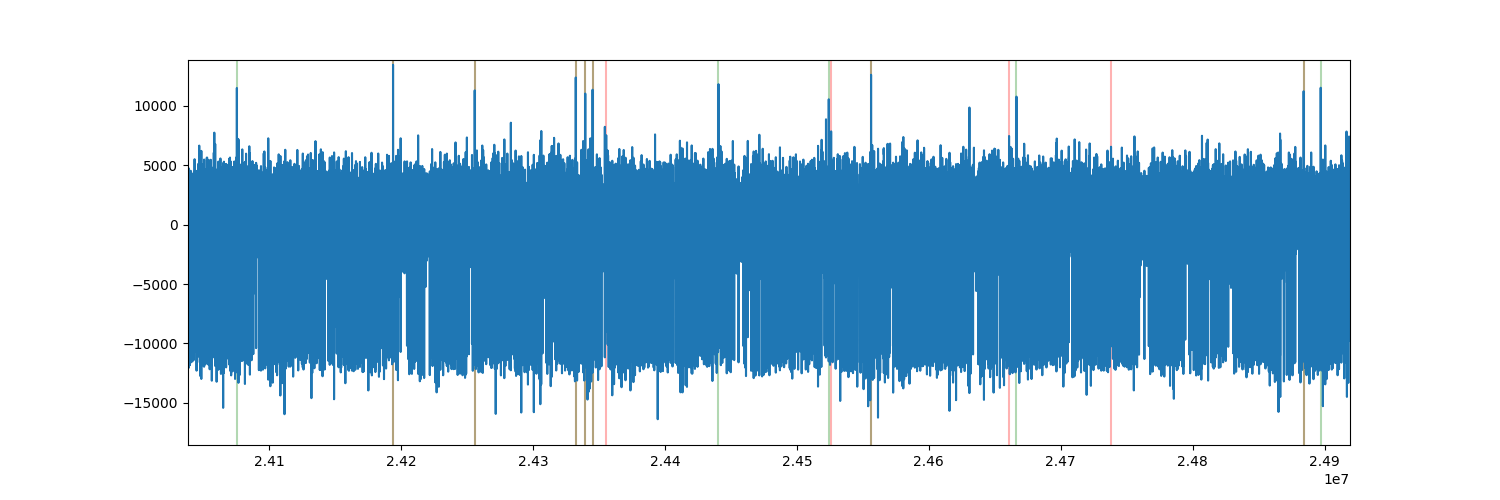

In [75]:
plt.figure(figsize=(15,5))
plt.plot(sss.voltage)
axvlines(plt.gca(), cs_predict, color='r', alpha=0.3)
axvlines(plt.gca(), cs_indices, color='g', alpha=0.3)


In [76]:
# prediction = clf.predict(x_test)
print(prediction.shape)
print('False negative error rate: ', np.count_nonzero((prediction - y_test)==-1)/np.sum(y_test))

print('False positive error rate: ', np.count_nonzero((prediction - y_test)==1)/float((np.sum(y_test==0))))

(70233,)
('False negative error rate: ', 0.0689252336448598)
('False positive error rate: ', 0.004771033627859377)


In [77]:
np.count_nonzero((prediction - y_test)==1)

331

In [ ]:
# write to csv, if there is spiketrain in the smr files. if there is, write the size of spiketrain channels
# from neo.io import Spike2IO
# import csv
# import os
# source_path = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/'
# with open('cs_spike_train_index.csv', 'a') as f:
#     for root, dirnames, filenames in os.walk(source_path):
#         for filename in filenames:
#             if filename.endswith('smr'):
#                 f_name = os.path.join(root, filename)
#                 csv_row = [f_name];
#                 try:
#                     neo_reader = Spike2IO(filename=f_name)
#                     neo_data = neo_reader.read()
#                     data_block = neo_data[0]
#                     seg = data_block.segments[0]
#                     if seg.spiketrains:
#                         for st in seg.spiketrains:
#                             csv_row = csv_row + [st.size]
#                     print(csv_row)
#                     writer = csv.writer(f)
#                     writer.writerow(csv_row)
#                 except Exception:
#                     pass
                